In [1]:
# import shutil
# import os

# # Delete HateDeRC directory if it exists
# if os.path.exists('HateDeRC'):
#   shutil.rmtree('HateDeRC')
# !git clone https://github.com/jamesalv/HateDeRC
# %cd HateDeRC

In [2]:
from TrainingConfig import TrainingConfig
from typing import Dict, Any, Tuple, List
import numpy as np
import torch
from transformers import AutoTokenizer
import json

In [3]:
data_path = 'Data/dataset.json'

In [4]:
config = TrainingConfig()

config.model_name = 'distilbert-base-uncased'

config.class_weighting = False
config.learning_rate = 1e-5
config.batch_size = 32
config.num_epochs = 1
config.hidden_dropout_prob = 0.2

# Attention Training Configurations
config.train_attention = False
config.lambda_attn = 1
config.ranking_margin = 0.1        # Minimum margin between token pairs
config.ranking_threshold = 0.05    # Min difference to consider pairs significant

#
config.use_multi_layer_loss = False
config.lower_loss_weight = 0.5
config.upper_loss_weight = 0.5

In [5]:
# Seed all randomness for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(config.seed)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(config.seed)
np.random.seed(config.seed)

# Preprocessing

In [6]:
import re
import string

def deobfuscate_text(text):
    """
    Normalize common text obfuscation patterns to reveal original words.
    Useful for hate speech detection and content analysis.

    Args:
        text (str): Input text with potential obfuscations

    Returns:
        str: Text with obfuscations normalized
    """
    if not isinstance(text, str):
        return text

    # Make a copy to work with
    result = text.lower()

    # 1. Handle asterisk/symbol replacements
    symbol_patterns = {
        # Common profanity
        r'f\*+c?k': 'fuck',
        r'f\*+': 'fuck',
        r's\*+t': 'shit',
        r'b\*+ch': 'bitch',
        r'a\*+s': 'ass',
        r'd\*+n': 'damn',
        r'h\*+l': 'hell',
        r'c\*+p': 'crap',

        # Slurs and hate speech terms (be comprehensive for detection)
        r'n\*+g+[aer]+': 'nigger',  # Various n-word obfuscations
        r'f\*+g+[ot]*': 'faggot',
        r'r\*+[dt]ard': 'retard',
        r'sp\*+c': 'spic',

        # Other symbols
        r'@ss': 'ass',
        r'b@tch': 'bitch',
        r'sh!t': 'shit',
        r'f#ck': 'fuck',
        r'd@mn': 'damn',
    }

    for pattern, replacement in symbol_patterns.items():
        result = re.sub(pattern, replacement, result, flags=re.IGNORECASE)

    # 2. Handle character spacing (f u c k -> fuck)
    spacing_patterns = {
        r'\bf\s+u\s+c\s+k\b': 'fuck',
        r'\bs\s+h\s+i\s+t\b': 'shit',
        r'\bd\s+a\s+m\s+n\b': 'damn',
        r'\bh\s+e\s+l\s+l\b': 'hell',
        r'\ba\s+s\s+s\b': 'ass',
        r'\bc\s+r\s+a\s+p\b': 'crap',
    }

    for pattern, replacement in spacing_patterns.items():
        result = re.sub(pattern, replacement, result, flags=re.IGNORECASE)

    # 3. Handle number/letter substitutions
    leet_patterns = {
        # Basic leet speak
        r'\b3\s*1\s*1\s*3\b': 'elle',  # 3113 -> elle
        r'\bf4g\b': 'fag',
        r'\bf4gg0t\b': 'faggot',
        r'\bn00b\b': 'noob',
        r'\bl33t\b': 'leet',
        r'\bh4t3\b': 'hate',
        r'\b5h1t\b': 'shit',
        r'\bf0ck\b': 'fock',
    }

    for pattern, replacement in leet_patterns.items():
        result = re.sub(pattern, replacement, result, flags=re.IGNORECASE)

    # 4. Handle repeated characters and separators
    # Remove excessive punctuation between letters
    result = re.sub(r'([a-z])[^\w\s]+([a-z])', r'\1\2', result)

    # Handle underscore separation
    result = re.sub(r'([a-z])_+([a-z])', r'\1\2', result)

    # Handle dot separation
    result = re.sub(r'([a-z])\.+([a-z])', r'\1\2', result)

    # 5. Handle common misspellings/variations used for evasion
    evasion_patterns = {
        r'\bfuk\b': 'fuck',
        r'\bfuq\b': 'fuck',
        r'\bfck\b': 'fuck',
        r'\bshyt\b': 'shit',
        r'\bshit\b': 'shit',
        r'\bbiatch\b': 'bitch',
        r'\bbeatch\b': 'bitch',
        r'\basshole\b': 'asshole',
        r'\ba55hole\b': 'asshole',
        r'\btard\b': 'retard',
        r'\bfagg\b': 'fag',
    }

    for pattern, replacement in evasion_patterns.items():
        result = re.sub(pattern, replacement, result, flags=re.IGNORECASE)

    # 6. Clean up multiple spaces
    result = re.sub(r'\s+', ' ', result).strip()

    return result

In [7]:
def aggregate_rationales(rationales, labels, post_length, drop_abnormal=False):
    """
    If all 3 annotators are normal → 3 zero spans → average (all zeros).
    If k annotators are non-normal and k spans exist → average the k spans (no added zeros).
    If k non-normal but fewer than k spans:
        If the missing annotators are non-normal → do not fill with zeros; average only existing spans and record rationale_support = #spans.
        If the missing annotators are normal (e.g., 2 hate + 1 normal + 2 spans) → append one zero span for the normal.
    """
    count_normal = labels.count(0)
    count_hate = labels.count(1)
    count_rationales = len(rationales)
    pad = np.zeros(post_length, dtype="int").tolist()

    # If there are hate labels but no rationales, something is wrong
    if count_hate > 0 and count_rationales == 0:
        if drop_abnormal:
            return None

        # Else just fill with 0
        return np.zeros(post_length).tolist()

    # If all annotators are normal, return all zeros
    if count_normal == 3:
        return np.zeros(post_length).tolist()

    # If we have hate annotators
    if count_hate > 0:
        # Case 1: Number of rationales matches number of hate annotators
        if count_rationales == count_hate:
            return np.average(rationales, axis=0).tolist()

        # Case 2: Fewer rationales than hate annotators
        elif count_rationales < count_hate:
            # Add zero padding for normal annotators only
            rationales_copy = rationales.copy()
            zeros_to_add = count_normal
            for _ in range(zeros_to_add):
                rationales_copy.append(pad)
            return np.average(rationales_copy, axis=0).tolist()

        # Case 3: More rationales than hate annotators (shouldn't happen normally)
        else:
            # Just average what we have
            return np.average(rationales, axis=0).tolist()

    # Fallback: return zeros if no clear case matches
    return np.zeros(post_length).tolist()

In [8]:
from typing import List, Tuple

def preprocess_text(raw_text):
    preprocessed_text = raw_text
    # # Remove HTML tags <>
    preprocessed_text = preprocessed_text.replace("<", "").replace(">", "")
    # # De-Obsfucate Patterns
    preprocessed_text = deobfuscate_text(preprocessed_text)

    return preprocessed_text


def create_text_segment(
    text_tokens: List[str], rationale_mask: List[int]
) -> List[Tuple[List[str], int]]:
    """
    Process a rationale mask to identify contiguous segments of highlighted text.
    Then create a segmented representation of the tokens

    Args:
        text_tokens: Original text tokens
        mask: Binary mask where 1 indicates a highlighted token (this consists of mask from 3 annotators)

    Returns:
        A list of tuples (text segment, mask value)
    """
    # Handle case where mask is empty (no rationale provided), usually this is normal classification
    mask = rationale_mask

    # for mask in all_rationale_mask:
    # Find breakpoints (transitions between highlighted/1 and non-highlighted/0)
    breakpoints = []
    mask_values = []

    # Always start with position 0
    breakpoints.append(0)
    mask_values.append(mask[0])

    # Find transitions in the mask
    for i in range(1, len(mask)):
        if mask[i] != mask[i - 1]:
            breakpoints.append(i)
            mask_values.append(mask[i])

    # Always end with the length of the text
    if breakpoints[-1] != len(mask):
        breakpoints.append(len(mask))

    # Create segments based on breakpoints
    segments = []
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segments.append((text_tokens[start:end], mask_values[i]))

    return segments


def align_rationales(tokens, rationales, tokenizer, max_length=128):
    """
    Align rationales with tokenized text while handling different tokenizer formats.

    Args:
        tokens: Original text tokens
        rationales: Original rationale masks
        tokenizer: The tokenizer to use
        max_length: Maximum sequence length

    Returns:
        Dictionary with tokenized inputs and aligned rationale masks
    """
    segments = create_text_segment(tokens, rationales)
    all_human_rationales = []
    all_input_ids = []
    all_attention_mask = []
    all_token_type_ids = []
    all_rationales = []
    for text_segment, rationale_value in segments:
        inputs = {}
        concatenated_text = " ".join(text_segment)
        processed_segment = preprocess_text(concatenated_text)
        tokenized = tokenizer(
            processed_segment, add_special_tokens=False, return_tensors="pt"
        )

        # Extract the relevant data
        segment_input_ids = tokenized["input_ids"][0]
        segment_attention_mask = tokenized["attention_mask"][0]
        # Handle token_type_ids if present
        if "token_type_ids" in tokenized:
            segment_token_type_ids = tokenized["token_type_ids"][0]
            all_token_type_ids.extend(segment_token_type_ids)

        # Add input IDs and attention mask
        all_input_ids.extend(segment_input_ids)
        all_attention_mask.extend(segment_attention_mask)

        # Add rationales (excluding special tokens)
        segment_rationales = [rationale_value] * len(segment_input_ids)
        all_rationales.extend(segment_rationales)
    # Get special token IDs
    cls_token_id = tokenizer.cls_token_id
    sep_token_id = tokenizer.sep_token_id

    # Add special tokens at the beginning and end
    all_input_ids = [cls_token_id] + all_input_ids + [sep_token_id]
    all_attention_mask = [1] + all_attention_mask + [1]

    # Handle token_type_ids if the model requires it
    if hasattr(tokenizer, "create_token_type_ids_from_sequences"):
        all_token_type_ids = tokenizer.create_token_type_ids_from_sequences(
            all_input_ids[1:-1]
        )
    elif all_token_type_ids:
        all_token_type_ids = [0] + all_token_type_ids + [0]
    else:
        all_token_type_ids = [0] * len(all_input_ids)

    # Check tokenized vs rationales length
    if len(all_input_ids) != len(all_attention_mask):
        print("Warning: length of tokens and rationales do not match")

    # Add zero rationale values for special tokens
    all_rationales = [0] + all_rationales + [0]

    # Truncate to max length if needed
    if len(all_input_ids) > max_length:
        print("WARNING: NEED TO TRUNCATE")
        all_input_ids = all_input_ids[:max_length]
        all_attention_mask = all_attention_mask[:max_length]
        all_token_type_ids = all_token_type_ids[:max_length]
        all_rationales = all_rationales[:max_length]

    # Pad to max_length if needed
    pad_token_id = tokenizer.pad_token_id
    padding_length = max_length - len(all_input_ids)

    if padding_length > 0:
        all_input_ids = all_input_ids + [pad_token_id] * padding_length
        all_attention_mask = all_attention_mask + [0] * padding_length
        all_token_type_ids = all_token_type_ids + [0] * padding_length
        all_rationales = all_rationales + [0] * padding_length

    # Convert lists to tensors
    inputs = {
        "input_ids": torch.tensor([all_input_ids], dtype=torch.long),
        "attention_mask": torch.tensor([all_attention_mask], dtype=torch.long),
        "token_type_ids": (
            torch.tensor([all_token_type_ids], dtype=torch.long)
            if "token_type_ids" in tokenizer.model_input_names
            else None
        ),
        "rationales": torch.tensor([all_rationales], dtype=torch.float32),
    }

    # Remove None values
    inputs = {k: v for k, v in inputs.items() if v is not None}
    return inputs

In [9]:
import re
import json
import os
import string
from collections import Counter
from tqdm import tqdm
import more_itertools as mit


def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]


def process_and_convert_data(
    data,
    tokenizer,
    post_id_divisions,
    save_path="Data/explanations/",
    drop_abnormal=False,
):
    """
    Combined function that processes raw entries and converts to ERASER format in one pass.
    Also splits data into train/val/test sets.
    """
    print("Processing and converting data...")

    # Initialize outputs
    train_data = []
    val_data = []
    test_data = []
    dropped = 0

    # Create directories if saving splits
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        os.makedirs(os.path.join(save_path, "docs"), exist_ok=True)
        train_fp = open(os.path.join(save_path, "train.jsonl"), "w")
        val_fp = open(os.path.join(save_path, "val.jsonl"), "w")
        test_fp = open(os.path.join(save_path, "test.jsonl"), "w")

    for key, value in tqdm(data.items()):
        try:
            # Extract labels
            labels = [
                1 if annot["label"] in ["hatespeech", "offensive"] else 0
                for annot in value["annotators"]
            ]

            # Process rationales
            rationales = value.get("rationales", [])
            aggregated_rationale = aggregate_rationales(
                rationales,
                labels,
                len(value["post_tokens"]),
                drop_abnormal=drop_abnormal,
            )

            if aggregated_rationale is None:
                dropped += 1
                continue

            inputs = align_rationales(
                value["post_tokens"], aggregated_rationale, tokenizer
            )

            # Calculate labels
            hard_label = Counter(labels).most_common(1)[0][0]
            soft_label = sum(labels) / len(labels)

            # Determine target groups (mentioned at least 3 times)
            target_groups = [
                t for annot in value["annotators"] for t in annot["target"]
            ]
            filtered_targets = [k for k, v in Counter(target_groups).items() if v > 2]

            # Create processed entry
            processed_entry = {
                "post_id": key,
                "input_ids": inputs["input_ids"],
                "attention_mask": inputs["attention_mask"],
                "rationales": inputs["rationales"],
                "raw_text": " ".join(value["post_tokens"]),
                "hard_label": hard_label,
                "soft_label": soft_label,
                "target_groups": filtered_targets,
            }

            # Convert to ERASER format if it's hateful/offensive content
            if hard_label == 1 and save_path:
                input_ids_list = inputs["input_ids"].squeeze().tolist()
                rationales_list = inputs["rationales"].squeeze().ceil().int().tolist()

                # Build evidences
                evidences = []
                indexes = sorted(
                    [i for i, each in enumerate(rationales_list) if each == 1]
                )
                for span in find_ranges(indexes):
                    if isinstance(span, int):
                        start, end = span, span + 1
                    else:
                        start, end = span[0], span[1] + 1

                    evidences.append(
                        {
                            "docid": key,
                            "end_sentence": -1,
                            "end_token": end,
                            "start_sentence": -1,
                            "start_token": start,
                            "text": " ".join(
                                [str(x) for x in input_ids_list[start:end]]
                            ),
                        }
                    )

                eraser_entry = {
                    "annotation_id": key,
                    "classification": str(hard_label),
                    "evidences": [evidences],
                    "query": "What is the class?",
                    "query_type": None,
                }

                # Save document
                with open(os.path.join(save_path, "docs", key), "w") as fp:
                    fp.write(" ".join([str(x) for x in input_ids_list if x > 0]))

                # Write to appropriate split
                if key in post_id_divisions["train"]:
                    train_fp.write(json.dumps(eraser_entry) + "\n")
                elif key in post_id_divisions["val"]:
                    val_fp.write(json.dumps(eraser_entry) + "\n")
                elif key in post_id_divisions["test"]:
                    test_fp.write(json.dumps(eraser_entry) + "\n")

            # Add to appropriate split list
            if key in post_id_divisions["train"]:
                train_data.append(processed_entry)
            elif key in post_id_divisions["val"]:
                val_data.append(processed_entry)
            elif key in post_id_divisions["test"]:
                test_data.append(processed_entry)

        except Exception as e:
            dropped += 1
            print(f"Error processing {key}: {e}")

    if save_path:
        train_fp.close()
        val_fp.close()
        test_fp.close()

    print(
        f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}, Dropped: {dropped}"
    )

    return {"train": train_data, "val": val_data, "test": test_data}

In [10]:
with open(data_path, 'r') as file:
    data = json.load(file)

with open('Data/post_id_divisions.json') as file:
    post_id_divisions = json.load(file)

# Process everything in one pass
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
splits = process_and_convert_data(
    data=data,
    tokenizer=tokenizer,
    post_id_divisions=post_id_divisions,
    save_path='Data/explanations/',
    drop_abnormal=False
)

# Access splits directly
train_data = splits['train']
val_data = splits['val']
test_data = splits['test']

Processing and converting data...


 37%|███▋      | 7380/20148 [00:10<00:15, 803.81it/s]

 89%|████████▉ | 18006/20148 [00:25<00:03, 636.36it/s]

Error processing 24439295_gab: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


100%|██████████| 20148/20148 [00:29<00:00, 688.90it/s]

Train: 15382, Val: 1922, Test: 1924, Dropped: 1


# Training

In [11]:
from HateDataset import HateDataset

# Create datasets with pre-tokenized data
train_dataset = HateDataset(data=train_data)
val_dataset = HateDataset(data=val_data)
test_dataset = HateDataset(data=test_data)

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Use shuffle=False for validation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Use shuffle=False for testing

## Bias

In [13]:
def get_bias_evaluation_samples(data, method, group):
    """
    Get positive and negative sample IDs for bias evaluation based on method and group

    Args:
        data: list of data entries
        method: Bias evaluation method ('subgroup', 'bpsn', or 'bnsp')
        group: Target group to evaluate

    Returns:
        Tuple of (positive_ids, negative_ids)
    """
    positive_ids = []
    negative_ids = []

    for idx, row in enumerate(data):
        target_groups = row['target_groups']
        if target_groups is None:
            continue

        is_in_group = group in target_groups

        # Convert various label formats to binary toxic/non-toxic
        if 'hard_label' in row:
            is_toxic = row['hard_label'] == 1
        else:
            continue

        if method == 'subgroup':
            # Only consider samples mentioning the group
            if is_in_group:
                if is_toxic:
                    positive_ids.append(idx)
                else:
                    negative_ids.append(idx)

        elif method == 'bpsn':
            # Compare non-toxic posts mentioning the group with toxic posts NOT mentioning the group
            if is_in_group and not is_toxic:
                negative_ids.append(idx)
            elif not is_in_group and is_toxic:
                positive_ids.append(idx)

        elif method == 'bnsp':
            # Compare toxic posts mentioning the group with non-toxic posts NOT mentioning the group
            if is_in_group and is_toxic:
                positive_ids.append(idx)
            elif not is_in_group and not is_toxic:
                negative_ids.append(idx)

    return positive_ids, negative_ids

In [14]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score

def calculate_gmb_metrics(
    test_data: List[Dict[str, Any]],
    probabilities: np.ndarray,
    target_groups: List[str]
):
    """
    Calculate GMB (Generalized Mean of Bias) AUC metrics from model predictions

    Args:
        probabilities: Model's probability outputs
        test_data: List of test data entries
        target_groups: List of target groups to evaluate

    Returns:
        Dictionary with GMB metrics
    """
    # Create mappings from post_id to predictions and ground truth
    prediction_scores = defaultdict(lambda: defaultdict(dict))
    ground_truth = {}

    for idx, row in enumerate(test_data):
        prediction_scores[idx] = probabilities[idx, 1]
        ground_truth[idx] = row['hard_label']

    # Calculate metrics for each target group and method
    bias_metrics = {}
    methods = ['subgroup', 'bpsn', 'bnsp']

    for method in methods:
        bias_metrics[method] = {}  # Initialize nested dictionary for each method
        for group in target_groups:
            # Get positive and negative samples based on the method
            positive_ids, negative_ids = get_bias_evaluation_samples(test_data, method, group)

            if len(positive_ids) == 0 or len(negative_ids) == 0:
                print(f"Skipping {method} for group {group}: no samples found")
                continue  # Skip if no samples for this group/method

            # Collect ground truth and predictions
            y_true = []
            y_score = []

            for post_id in positive_ids:
                if post_id in ground_truth and post_id in prediction_scores:
                    y_true.append(ground_truth[post_id])
                    y_score.append(prediction_scores[post_id])

            for post_id in negative_ids:
                if post_id in ground_truth and post_id in prediction_scores:
                    y_true.append(ground_truth[post_id])
                    y_score.append(prediction_scores[post_id])

            # Calculate AUC if we have enough samples with both classes
            if len(y_true) > 10 and len(set(y_true)) > 1:
                try:
                    auc = roc_auc_score(y_true, y_score)
                    bias_metrics[method][group] = auc
                except ValueError:
                    print(f"Could not compute AUC for {method} and group {group} due to ValueError")
                    pass

    # Calculate GMB for each method
    gmb_metrics = {}
    power = -5  # Power parameter for generalized mean

    for method in methods:
        if not bias_metrics[method]:
            continue

        scores = list(bias_metrics[method].values())
        if not scores:
            continue

        # Calculate generalized mean with p=-5
        power_mean = np.mean([score ** power for score in scores]) ** (1/power)
        gmb_metrics[f'GMB-{method.upper()}-AUC'] = power_mean

    # Calculate a combined GMB score that includes all methods
    all_scores = []
    for method in methods:
        all_scores.extend(list(bias_metrics[method].values()))

    if all_scores:
        gmb_metrics['GMB-COMBINED-AUC'] = np.mean([score ** power for score in all_scores]) ** (1/power)

    return gmb_metrics, bias_metrics

## XAI

In [15]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple
import json
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
)


class FaithfulnessMetrics:
    """
    Compute faithfulness metrics using the model's existing predict() method.
    Creates modified datasets and uses DataLoader for efficient batched processing.
    """

    def __init__(self, model, tokenizer, dataset_class, batch_size=32):
        self.model = model
        self.tokenizer = tokenizer
        self.dataset_class = dataset_class
        self.batch_size = batch_size

        # Get special token IDs
        self.special_token_ids = {
            tokenizer.cls_token_id,
            tokenizer.sep_token_id,
        }
        self.special_token_ids = {x for x in self.special_token_ids if x is not None}

    def compute_all_metrics(
        self,
        test_data: List[Dict],  # Your original test data
        test_results: Dict,  # Results from prediction
        k: int = 5,  # Number of top tokens to consider
        eraser_save_path: str = "Data/eraser_formatted_results.jsonl",
    ) -> Dict[str, float]:
        """
        Compute all ERASER metrics efficiently using DataLoader approach

        Args:
            test_data: List of test instances (each with input_ids, attention_mask, rationales, labels)
            test_results: List of dictionaries containing attention scores for each instance

        Returns:
            Dictionary with all metrics
        """
        print("Computing ERASER metrics using DataLoader approach...")

        # Extract lists for easier processing
        input_ids_list = [item["input_ids"] for item in test_data]
        attention_masks_list = [item["attention_mask"] for item in test_data]
        human_rationales = [item["rationales"] for item in test_data]
        attention_scores = [item for item in test_results["attentions"]]

        # 1. Extract top-k as hard predictions
        print("[1/5] Extracting top-k tokens for hard rationale predictions...")
        hard_predictions = self._extract_top_k_tokens(
            attention_scores, attention_masks_list, input_ids_list, k
        )

        hard_rationale_predictions, soft_rationale_predictions = self._convert_attention_to_evidence_format(input_ids_list, attention_scores, hard_predictions)

        # 1. FAITHFULNESS METRICS
        print("[2/5] Computing comprehensiveness scores...")
        raw_comprehensiveness, comprehensiveness_scores = (
            self._compute_comprehensiveness(test_data, test_results, hard_predictions)
        )

        print("[3/5] Computing sufficiency scores...")
        raw_sufficiency, sufficiency_scores = self._compute_sufficiency(
            test_data, test_results, hard_predictions
        )

        # 4. Convert to eraser format
        print("[4/5] Converting results to ERASER format and saving...")
        results_eraser = self._convert_result_to_eraser_format(test_results, hard_rationale_predictions, soft_rationale_predictions, raw_sufficiency, raw_comprehensiveness)
        # Convert to JSONL format
        jsonl_output = '\n'.join([json.dumps(entry) for entry in results_eraser])
        with open(eraser_save_path, 'w') as f:
            f.write(jsonl_output)
        
        # 5. Calculate ERASER metrics
        print("[5/5] Calculating ERASER metrics...")
        
        return {
            'comprehensiveness': float(np.average(comprehensiveness_scores)),
            'sufficiency': float(np.average(sufficiency_scores)),
            
        }

    def _convert_attention_to_evidence_format(self, input_ids_list, attention_scores, hard_predictions):
        # 2. Collect evidence
        hard_rationale_predictions = []
        for idx, hp in enumerate(hard_predictions):
            evidences = []
            indexes = sorted([i for i, each in enumerate(hp.tolist()) if each == 1])
            for span in find_ranges(indexes):
                if isinstance(span, int):
                    start, end = span, span + 1
                else:
                    start, end = span[0], span[1] + 1

                evidences.append({
                    "start_token": start,
                    "end_token": end,
                })
            hard_rationale_predictions.append(evidences)

        soft_rationale_predictions = []
        for att in attention_scores:
            pred = [x for x in att if x > 0]
            soft_rationale_predictions.append(pred)

        return hard_rationale_predictions, soft_rationale_predictions

    def _convert_result_to_eraser_format(
        self,
        test_result: Dict,
        hard_rationale_predictions,
        soft_rationale_predictions,
        sufficiency_scores: np.ndarray,
        comprehensiveness_scores: np.ndarray,
    ):
        all_entries = []
        for idx, data in enumerate(test_result["post_id"]):
            entry = {
            'annotation_id': data,
            'classification': str(int(test_result["predictions"][idx])),
            'classification_scores': {
                0: float(test_result["probabilities"][idx][0]),
                1: float(test_result["probabilities"][idx][1]),
            },
            'rationales': [
                {
                    "docid": data,
                    "hard_rationale_predictions": hard_rationale_predictions[idx],
                    "soft_rationale_predictions": [float(x) for x in soft_rationale_predictions[idx]],
                }
            ],
            'sufficiency_classification_scores': {
                0: float(sufficiency_scores[idx][0]),
                1: float(sufficiency_scores[idx][1])
            },
            'comprehensiveness_classification_scores': {
                0: float(comprehensiveness_scores[idx][0]),
                1: float(comprehensiveness_scores[idx][1])
            }
            }
            all_entries.append(entry)

        return all_entries

    def _extract_top_k_tokens(
        self,
        attention_scores: List[np.ndarray],
        attention_masks_list: List[torch.Tensor],
        input_ids_list: List[torch.Tensor],
        k: int,
    ) -> List[np.ndarray]:
        """Extract top-k content tokens as hard predictions"""
        hard_predictions = []

        for idx, (attn, mask) in enumerate(zip(attention_scores, attention_masks_list)):
            pred_mask = np.zeros_like(attn, dtype=int)
            valid_positions = mask.bool().cpu().numpy().flatten()

            # Exclude special tokens
            input_ids = input_ids_list[idx].cpu().numpy().flatten()
            is_special = np.isin(input_ids, list(self.special_token_ids))
            content_positions = valid_positions & ~is_special

            content_attn = attn[content_positions]

            if k > 0 and len(content_attn) > 0:
                k_actual = min(k, len(content_attn))
                top_k_within_content = np.argsort(content_attn)[-k_actual:]
                content_indices = np.where(content_positions)[0]
                top_k_indices = content_indices[top_k_within_content]
                pred_mask[top_k_indices] = 1

            hard_predictions.append(pred_mask)

        return hard_predictions
    
    def _compute_comprehensiveness(
        self,
        test_data: List[Dict],
        test_results: Dict,
        hard_predictions: List[np.ndarray],
    ) -> Tuple[float, List[float]]:
        """
        Compute comprehensiveness: how much does REMOVING rationales hurt?
        Uses DataLoader approach for efficiency
        """
        # Create modified dataset (remove rationales from attention mask)
        modified_data = []
        for item, rationale_mask in zip(test_data, hard_predictions):
            modified_item = self._create_comprehensiveness_instance(
                item, rationale_mask
            )
            modified_data.append(modified_item)

        # Create DataLoader
        modified_dataset = self.dataset_class(modified_data)
        modified_loader = DataLoader(
            modified_dataset, batch_size=self.batch_size, shuffle=False
        )

        # Get predictions using model's predict method
        results = self.model.predict(modified_loader, return_attentions=False)
        modified_probs = results["probabilities"]

        # Calculate comprehensiveness scores
        comprehensiveness_scores = []
        for idx, (prob, label) in enumerate(zip(test_results["probabilities"], test_results['predictions'])):
            original_prob = prob[
                label
            ]  # Probability from normal prediction process for the label
            modified_prob = modified_probs[idx][label]

            # Comprehensiveness = original - modified (higher is better)
            comp_score = original_prob - modified_prob
            comprehensiveness_scores.append(comp_score)

        return modified_probs, comprehensiveness_scores

    def _compute_sufficiency(
        self,
        test_data: List[Dict],
        test_results: Dict,
        hard_predictions: List[np.ndarray],
    ) -> Tuple[List[float], List[float]]:
        """
        Compute sufficiency: how well do ONLY rationales predict?
        Uses DataLoader approach for efficiency
        """
        # Create modified dataset (keep only rationales in attention mask)
        modified_data = []
        for item, rationale_mask in zip(test_data, hard_predictions):
            modified_item = self._create_sufficiency_instance(item, rationale_mask)
            modified_data.append(modified_item)

        # Create DataLoader
        modified_dataset = self.dataset_class(modified_data)
        modified_loader = DataLoader(
            modified_dataset, batch_size=self.batch_size, shuffle=False
        )

        # Get predictions using model's predict method
        results = self.model.predict(modified_loader, return_attentions=False)
        modified_probs = results["probabilities"]

        # Calculate sufficiency scores
        sufficiency_scores = []
        for idx, (prob, label) in enumerate(zip(test_results["probabilities"], test_results['predictions'])):
            original_prob = prob[
                label
            ]  # Probability from normal prediction process for the label
            modified_prob = modified_probs[idx][label]

            # Sufficiency = original - modified (lower/negative is better)
            suff_score = original_prob - modified_prob
            sufficiency_scores.append(suff_score)

        return modified_probs, sufficiency_scores

    def _create_comprehensiveness_instance(
        self, item: Dict, rationale_mask: np.ndarray
    ) -> Dict:
        """
        Create instance for comprehensiveness: REMOVE rationales from attention
        Keep: CLS + non-rationale content tokens + SEP
        """
        input_ids = item["input_ids"].cpu().numpy().flatten()
        orig_mask = item["attention_mask"].cpu().numpy().flatten()

        # Start with original mask
        new_mask = orig_mask.copy()

        # Zero out rationale positions (except CLS and SEP)
        for i in range(len(new_mask)):
            if rationale_mask[i] == 1:  # This is a rationale
                # Don't mask if it's CLS or SEP
                if input_ids[i] not in self.special_token_ids:
                    new_mask[i] = 0

        return {
            "post_id": item["post_id"],
            "input_ids": torch.tensor(input_ids).unsqueeze(0),
            "attention_mask": torch.tensor(new_mask).unsqueeze(0),
            "rationales": item["rationales"],
            "hard_label": item["hard_label"],
        }

    def _create_sufficiency_instance(
        self, item: Dict, rationale_mask: np.ndarray
    ) -> Dict:
        """
        Create instance for sufficiency: Keep ONLY rationales in attention
        Keep: CLS + rationale tokens + SEP
        """
        input_ids = item["input_ids"].cpu().numpy().flatten()
        orig_mask = item["attention_mask"].cpu().numpy().flatten()

        # Start with zeros
        new_mask = np.zeros_like(orig_mask)

        # Always keep CLS and SEP
        for i in range(len(new_mask)):
            if input_ids[i] in self.special_token_ids:
                new_mask[i] = 1

        # Keep rationale positions
        for i in range(len(new_mask)):
            if rationale_mask[i] == 1 and orig_mask[i] == 1:
                new_mask[i] = 1

        return {
            "post_id": item["post_id"],
            "input_ids": torch.tensor(input_ids).unsqueeze(0),
            "attention_mask": torch.tensor(new_mask).unsqueeze(0),
            "rationales": item["rationales"],
            "hard_label": item["hard_label"]
        }

# Experiment Management System

This notebook now uses a systematic experiment tracking system that organizes all outputs by experiment.

In [16]:
# ============================================================================
# FULL EXPERIMENT PIPELINE WITH TRACKING
# ============================================================================
from ExperimentManager import ExperimentManager
from HateClassifier import HateClassifier
from HateDataset import HateDataset
# 1. CREATE EXPERIMENT
experiment_manager = ExperimentManager(base_dir="./experiments")
experiment_dir = experiment_manager.create_experiment(
    config=config,
    custom_name="baseline_distilbert",  # Change this for each experiment
    description="Baseline model with distilbert-base-uncased, standard hyperparameters"
)

Created new experiment: 20251222_222826_baseline_distilbert_178780d5
Directory: experiments\20251222_222826_baseline_distilbert_178780d5
Description: Baseline model with distilbert-base-uncased, standard hyperparameters


In [17]:
from sklearn.utils.class_weight import compute_class_weight
y = [int(td['hard_label']) for td in train_data]

class_weights = torch.tensor(compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Ensure consistent order
    y=y
), dtype=torch.float32)

In [18]:
# 2. TRAIN MODEL (config.save_dir is automatically updated)
model = HateClassifier(config, class_weight=class_weights)
history = model.train(train_dataloader=train_loader, val_dataloader=val_loader)

# Save training history
experiment_manager.save_training_history(history)

Training on device: cuda
Model: distilbert-base-uncased
Epochs: 1
Batch size: 32
Gradient accumulation steps: 1
Effective batch size: 32
Learning rate: 1e-05
Mixed precision (AMP): True
Gradient clipping: 1.0

Loss Configuration:
  Multi-layer loss: False
  Attention supervision: False

Epoch 1/1


Evaluating: 100%|██████████| 61/61 [00:03<00:00, 17.90batch/s]



Epoch 1 Summary:
  Train Loss: 0.5223
  Val Loss:   0.4679
  Val Acc:    0.7742
  Val F1:     0.7684
  ✓ New best model saved! (F1: 0.7684)

Training completed!
Best F1 Score: 0.7684
Training history saved to: experiments\20251222_222826_baseline_distilbert_178780d5\checkpoints/training_history.json
Training history saved to: experiments\20251222_222826_baseline_distilbert_178780d5\metrics\training_history.json


In [19]:
# 3. EVALUATE MODEL
# Load best model
model.load_model('best_model')

# Evaluate model
result = model.predict(test_dataloader=test_loader, return_attentions=True)

# Save predictions
experiment_manager.save_predictions(result, filename="test_predictions.pkl")

Model loaded from: experiments\20251222_222826_baseline_distilbert_178780d5\checkpoints\best_model
Running inference on 61 batches...


Testing: 100%|██████████| 61/61 [00:03<00:00, 17.77batch/s]


Test Results:
  Test Loss:     0.4529
  Test Accuracy: 0.7853
  Test F1:       0.7796
Predictions saved to: experiments\20251222_222826_baseline_distilbert_178780d5\results\test_predictions.pkl


In [20]:
from collections import Counter
from itertools import chain

all_target_groups = chain.from_iterable([group['target_groups'] for group in train_data])
all_target_groups = [group for group in all_target_groups if group != 'None' and group != 'Other']
counter = Counter(all_target_groups)

n_common = 10
bias_target_groups = [tg[0] for tg in counter.most_common(n_common)]

# 4. BIAS EVALUATION
gmb_metrics, bias_details = calculate_gmb_metrics(
    test_data=test_data,
    probabilities=result['probabilities'],
    target_groups=bias_target_groups
)

# Save bias metrics
experiment_manager.save_bias_metrics(gmb_metrics, bias_details)


Bias metrics saved to: experiments\20251222_222826_baseline_distilbert_178780d5\metrics\bias_metrics.json


In [34]:
# 5. XAI EVALUATION (only on hate samples)
test_data_hate_only = []
test_results_hate_only = {'attentions': [], 'probabilities': [], 'predictions': [], 'post_id': [], 'labels': []}
for idx, td in enumerate(test_data):
    if td['hard_label'] == 1:
        test_data_hate_only.append(td)
        test_results_hate_only['attentions'].append(result['attentions'][idx])
        test_results_hate_only['probabilities'].append(result['probabilities'][idx])
        test_results_hate_only['predictions'].append(result['predictions'][idx])
        test_results_hate_only['post_id'].append(result['post_ids'][idx])
        test_results_hate_only['labels'].append(result['labels'][idx])

calculator = FaithfulnessMetrics(
    model=model,
    tokenizer=tokenizer,
    dataset_class=HateDataset,
    batch_size=32
)

k = 5
eraser_save_path = f"{experiment_dir}/results/test_explain_output.jsonl"
xai_results = calculator.compute_all_metrics(test_data_hate_only, test_results_hate_only, k, eraser_save_path)

# !git clone https://github.com/jayded/eraserbenchmark.git
# !sed -i "285s/.*/    labels=['0', '1']/" eraserbenchmark/rationale_benchmark/metrics.py
# !sed -i "286s/.*/    label_to_int = {'0':0, '1': 1}/" eraserbenchmark/rationale_benchmark/metrics.py
score_file = f"{experiment_dir}/metrics/xai_metrics.json"
!set PYTHONPATH=./eraserbenchmark;%PYTHONPATH% && python eraserbenchmark/rationale_benchmark/metrics.py --split test --strict --data_dir Data/explanations --results {eraser_save_path} --score_file {score_file}
with open(score_file) as f:
    xai_results = json.load(f)

Computing ERASER metrics using DataLoader approach...
[1/5] Extracting top-k tokens for hard rationale predictions...
[2/5] Computing comprehensiveness scores...
Running inference on 36 batches...


Testing: 100%|██████████| 36/36 [00:01<00:00, 18.47batch/s]



Test Results:
  Test Loss:     0.9281
  Test Accuracy: 0.3109
  Test F1:       0.2371
[3/5] Computing sufficiency scores...
Running inference on 36 batches...


Testing: 100%|██████████| 36/36 [00:01<00:00, 21.83batch/s]



Test Results:
  Test Loss:     0.5432
  Test Accuracy: 0.6550
  Test F1:       0.3958
[4/5] Converting results to ERASER format and saving...
[5/5] Calculating ERASER metrics...
{'annotation_id': '13851720_gab', 'classification': '1', 'classification_scores': {'0': 0.021145395934581757, '1': 0.9788546562194824}, 'rationales': [{'docid': '13851720_gab', 'hard_rationale_predictions': [{'start_token': 4, 'end_token': 5}, {'start_token': 14, 'end_token': 16}, {'start_token': 31, 'end_token': 32}, {'start_token': 35, 'end_token': 36}], 'soft_rationale_predictions': [0.06305968016386032, 0.017471451312303543, 0.021664030849933624, 0.014882443472743034, 0.038475051522254944, 0.014666500501334667, 0.016978396102786064, 0.010837199166417122, 0.003608392085880041, 0.003359486348927021, 0.018853601068258286, 0.005150247365236282, 0.02129555493593216, 0.022317929193377495, 0.05858197808265686, 0.08533990383148193, 0.0075513138435781, 0.021219080314040184, 0.010637179017066956, 0.00612887274473905

  5900 MainThread Error in instances: 0 instances fail validation: set()
  8784 MainThread No sentence level predictions detected, skipping sentence-level diagnostic
c:\Users\USER\miniconda3\envs\transformersv2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\miniconda3\envs\transformersv2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\miniconda3\envs\transformersv2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0

In [35]:
# 6. CREATE FINAL SUMMARY
final_summary = {
    "test_accuracy": float(result['accuracy']),
    "test_f1": float(result['f1']),
    "test_loss": float(result['loss']),
    "gmb_metrics": gmb_metrics,
    "xai_metrics": xai_results,
    "total_params": sum(p.numel() for p in model.base_model.parameters()),
}

# experiment_manager.save_final_metrics(final_summary)


In [36]:
for key, value in final_summary.items():
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"{key}.{k}: {v}")
        print()
    else:
        print(f"{key}: {value}")
    print()

test_accuracy: 0.7853430353430353

test_f1: 0.7795839453212225

test_loss: 0.45292079644125016

gmb_metrics.GMB-SUBGROUP-AUC: 0.8260663402500759
gmb_metrics.GMB-BPSN-AUC: 0.7297258760895191
gmb_metrics.GMB-BNSP-AUC: 0.7453478500920566
gmb_metrics.GMB-COMBINED-AUC: 0.7606720385455745


xai_metrics.classification_scores: {'accuracy': 0.797723292469352, 'aopc_thresholds': None, 'comprehensiveness': 0.2903742161750689, 'comprehensiveness_aopc': None, 'comprehensiveness_aopc_points': None, 'comprehensiveness_entropy': -0.16168975317675727, 'comprehensiveness_kl': 0.5284771328485485, 'prf': {'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 0.0}, '1': {'f1-score': 0.887481734047735, 'precision': 1.0, 'recall': 0.797723292469352, 'support': 1142.0}, 'accuracy': 0.797723292469352, 'macro avg': {'f1-score': 0.4437408670238675, 'precision': 0.5, 'recall': 0.398861646234676, 'support': 1142.0}, 'weighted avg': {'f1-score': 0.887481734047735, 'precision': 1.0, 'recall': 0.79772329

In [24]:
# 7. MARK EXPERIMENT AS COMPLETE
experiment_manager.mark_complete(
    status="completed",
    notes="Baseline experiment completed successfully"
)

print("\n" + "="*80)
print("EXPERIMENT COMPLETED!")
print(f"All results saved to: {experiment_dir}")
print("="*80)

Experiment 20251222_222826_baseline_distilbert_178780d5 marked as: completed

EXPERIMENT COMPLETED!
All results saved to: experiments\20251222_222826_baseline_distilbert_178780d5


## Experiment Management Utilities

Useful commands for managing and comparing experiments:

In [25]:
# View all experiments
experiment_manager = ExperimentManager()
experiment_manager.print_experiment_summary()


EXPERIMENT REGISTRY

Experiment ID: 20251218_210941_baseline_distilbert_455539da
  Status: running
  Timestamp: 2025-12-18T21:09:41.735990
  Name: baseline_distilbert
  Description: Baseline model with distilbert-base-uncased, standard hyperparameters
  Model: distilbert-base-uncased
  Epochs: 2, LR: 1e-05, BS: 32
  Directory: experiments\20251218_210941_baseline_distilbert_455539da

Experiment ID: 20251218_211335_baseline_distilbert_455539da
  Status: running
  Timestamp: 2025-12-18T21:13:35.969714
  Name: baseline_distilbert
  Description: Baseline model with distilbert-base-uncased, standard hyperparameters
  Model: distilbert-base-uncased
  Epochs: 2, LR: 1e-05, BS: 32
  Directory: experiments\20251218_211335_baseline_distilbert_455539da

Experiment ID: 20251218_211516_baseline_distilbert_455539da
  Status: running
  Timestamp: 2025-12-18T21:15:16.877120
  Name: baseline_distilbert
  Description: Baseline model with distilbert-base-uncased, standard hyperparameters
  Model: distil

In [26]:
# List only completed experiments
completed_experiments = experiment_manager.list_experiments(status="completed")
print(f"Found {len(completed_experiments)} completed experiments")
for exp in completed_experiments:
    print(f"  - {exp['experiment_id']}: {exp.get('description', 'No description')}")

Found 6 completed experiments
  - 20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd: No description provided
  - 20251219_213213_distilbert-base-uncased_attention_False_multiLayerLoss_False_178780d5: No description provided
  - 20251220_120628_distilbert-base-uncased_attention_False_multiLayerLoss_False_178780d5: No description provided
  - 20251220_125230_baseline_distilbert_455539da: Baseline model with distilbert-base-uncased, standard hyperparameters
  - 20251222_213022_baseline_distilbert_178780d5: Baseline model with distilbert-base-uncased, standard hyperparameters
  - 20251222_222826_baseline_distilbert_178780d5: Baseline model with distilbert-base-uncased, standard hyperparameters


In [27]:
experiment_dir

WindowsPath('experiments/20251222_222826_baseline_distilbert_178780d5')

In [28]:
# Compare multiple experiments
experiment_ids = [exp['experiment_id'] for exp in completed_experiments]
comparison = experiment_manager.compare_experiments(experiment_ids)

# Display comparison
for exp in comparison["experiments"]:
    print(f"\nExperiment: {exp['experiment_id']}")
    print(f"  Model: {exp['config'].get('model_name', 'N/A')}")
    print(f"  Learning Rate: {exp['config'].get('learning_rate', 'N/A')}")
    print(f"  Test F1: {exp['metrics'].get('test_f1', 'N/A')}")
    print(f"  Test Accuracy: {exp['metrics'].get('test_accuracy', 'N/A')}")


Experiment: 20251218_222417_distilbert-base-uncased_attention_True_multiLayerLoss_True_6449e6cd
  Model: distilbert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.7822098007853577
  Test Accuracy: 0.7920997920997921

Experiment: 20251219_213213_distilbert-base-uncased_attention_False_multiLayerLoss_False_178780d5
  Model: distilbert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.770608368494214
  Test Accuracy: 0.7728690228690228

Experiment: 20251220_120628_distilbert-base-uncased_attention_False_multiLayerLoss_False_178780d5
  Model: distilbert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.770608368494214
  Test Accuracy: 0.7728690228690228

Experiment: 20251220_125230_baseline_distilbert_455539da
  Model: distilbert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.7893371515202561
  Test Accuracy: 0.7972972972972973

Experiment: 20251222_213022_baseline_distilbert_178780d5
  Model: distilbert-base-uncased
  Learning Rate: 1e-05
  Test F1: 0.7795839453212225
  Test Accuracy: 

## Visualization Tools

Visualize and compare experiment results:

In [29]:
from experiment_visualization import (
    plot_training_curves,
    plot_metrics_comparison,
    plot_bias_metrics,
    plot_xai_metrics,
    create_experiment_report
)

Plot saved to training_curves.png


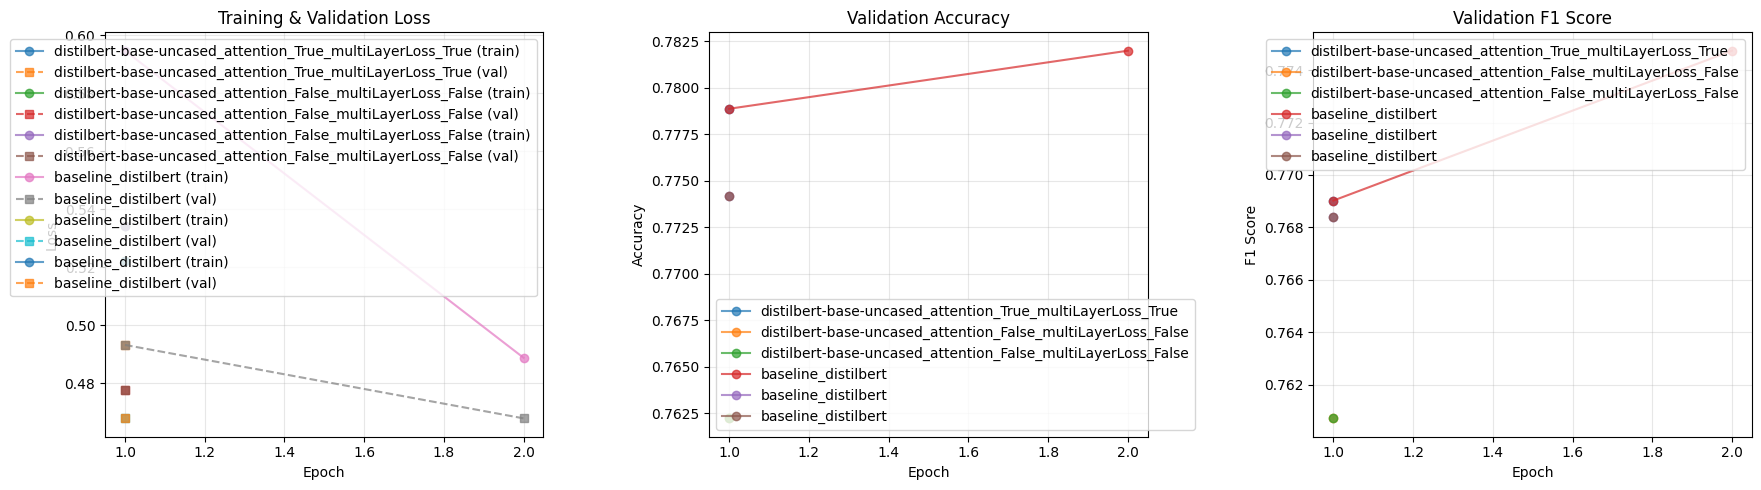

In [30]:
# Uncomment to use:
plot_training_curves(experiment_ids, save_path="training_curves.png")

Plot saved to metrics_comparison.png


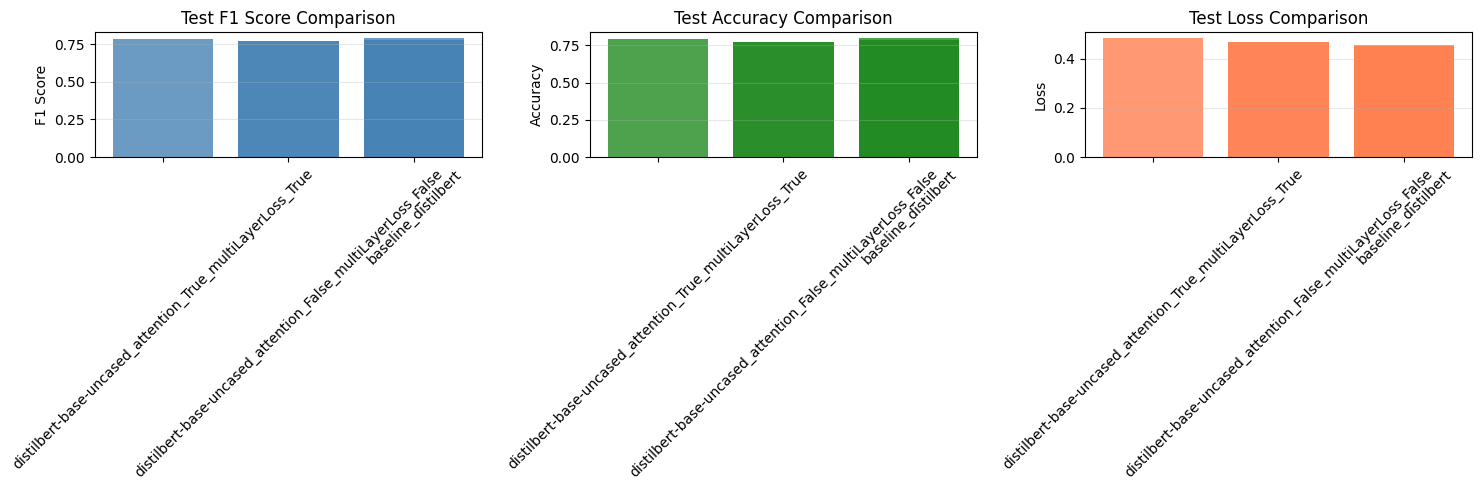

In [31]:
# Compare final metrics across experiments
plot_metrics_comparison(experiment_ids, save_path="metrics_comparison.png")

Plot saved to bias_comparison.png


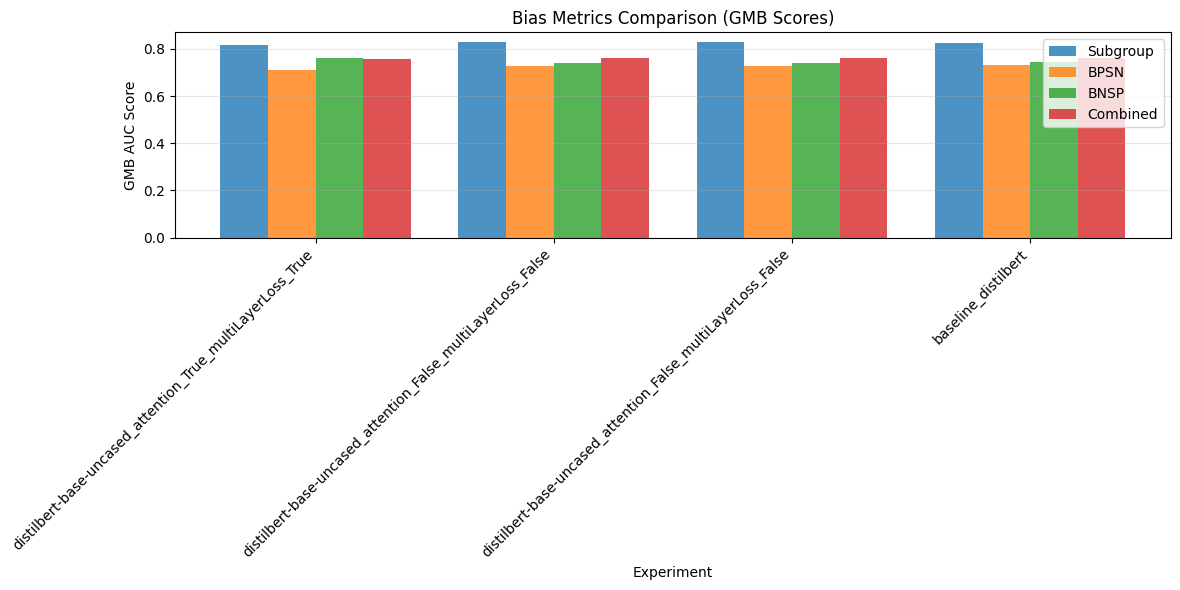

In [32]:
# Visualize bias metrics
plot_bias_metrics(experiment_ids, save_path="bias_comparison.png")

Plot saved to xai_comparison.png


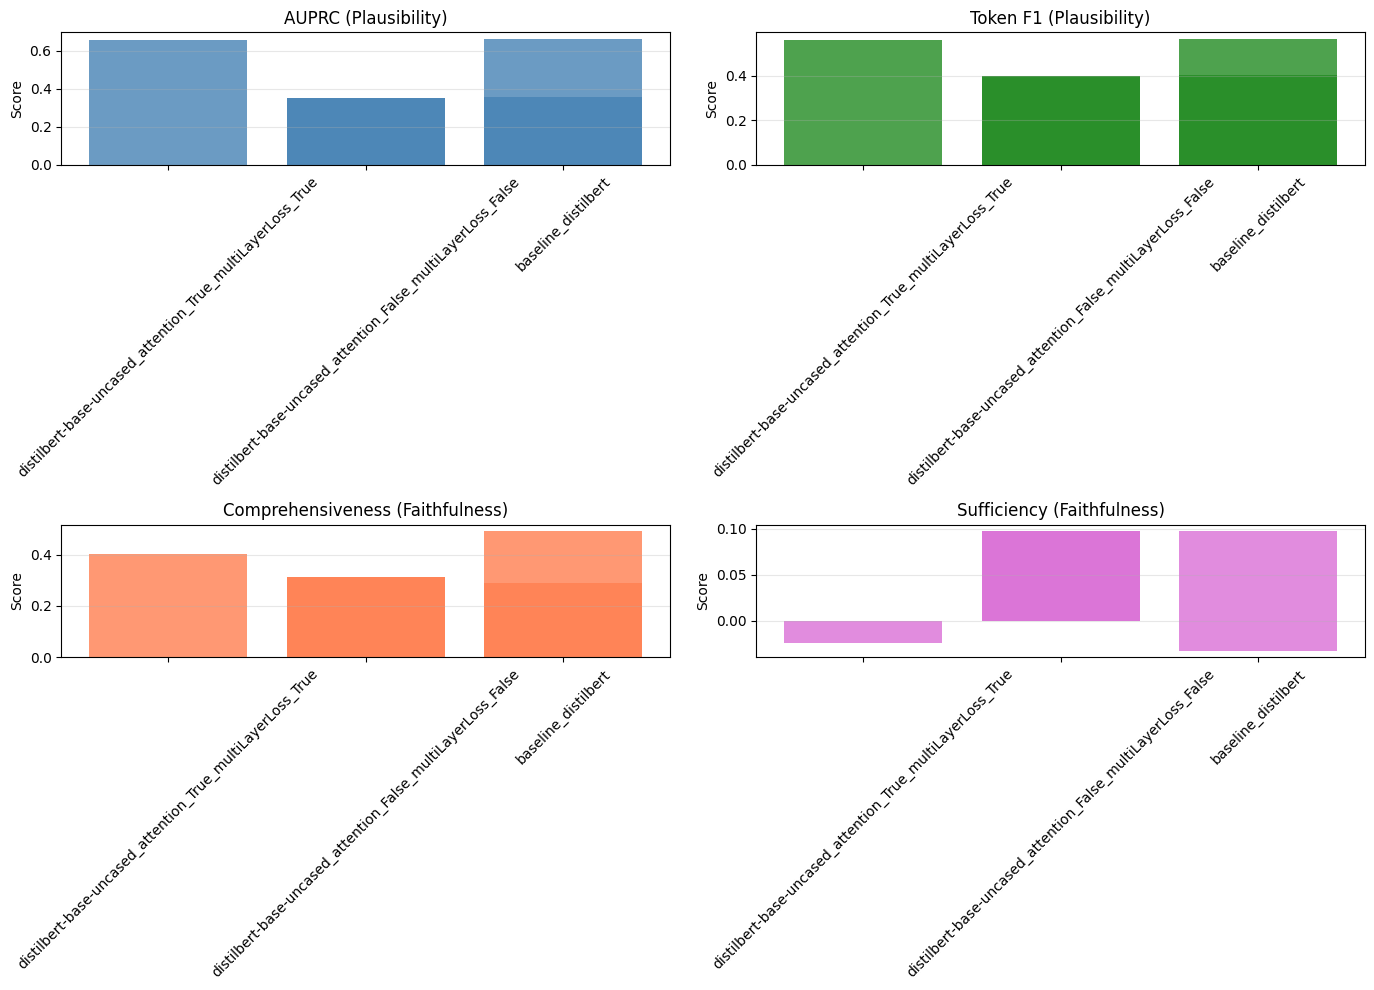

In [33]:
# Visualize XAI metrics
plot_xai_metrics(experiment_ids, save_path="xai_comparison.png")